# Simple Audio Processing

In [135]:
import os
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile as wav
import tensorflow as tf

## File input

In [6]:
def wav_read(filename):
    """Return 1D NumPy array of wave-formatted audio data denoted by filename.
    
    Input should be a string containing the path to a wave-formatted audio file.
    File should be uncompressed 16-bit."""
    sample_rate, data_2d = wav.read(filename)
    data_1d = [val for val, _ in data_2d]
    return np.array(data_1d)

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


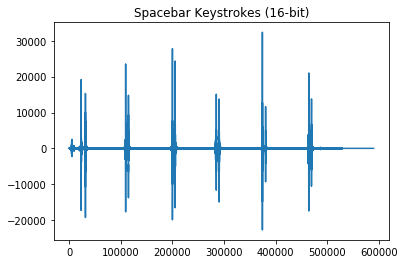

In [63]:
sound_file = 'datasets/samples/sample.wav'
spacebar_6x = wav_read(sound_file)

%matplotlib inline
plt.title('Spacebar Keystrokes (16-bit)')
plt.plot(spacebar_6x)
plt.show()

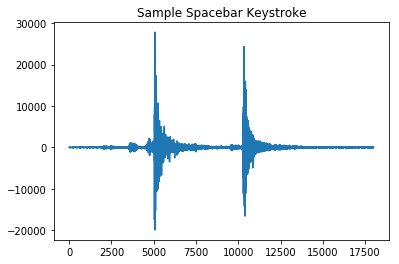

In [64]:
sample_keystroke = spacebar_6x[195000:213000]
plt.title('Sample Spacebar Keystroke')
plt.plot(sample_keystroke)
plt.show()

## Keystroke extraction

### Calculating Silence Threshold

In [7]:
def stats(array):
    """Return a dictionary containing relevant statistical data.
    
    :type array -- NumPy array
    :rtype dict
    """
    return {
        "length": len(array),
        "mean": np.mean(array),
        "median": np.median(array),
        "max": np.amax(array),
        "min": np.amin(array),
        "std deviation": np.std(array),
    }

#### Test 1 - Silence followed by 1 keystroke

length = 300000
mean = -0.46442333333333335
median = 0.0
max = 104
min = -104
std deviation = 22.414488044583774


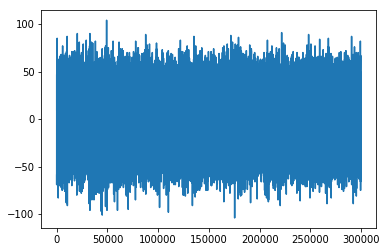

In [66]:
silence1_raw = wav_read('datasets/silence-threshold-tests/spacebar-1x-withsilence.wav')
silence1 = silence1_raw[:300000]

silence1_stats = stats(silence1)
for stat in silence1_stats:
    print(f'{stat} = {silence1_stats[stat]}')
    
plt.plot(silence1)
plt.show()

#### Test 2 - Silence followed by several keystrokes (same key, consistent pace)

length = 600000
mean = -0.46246
median = 0.0
max = 116
min = -121
std deviation = 24.353047531710143


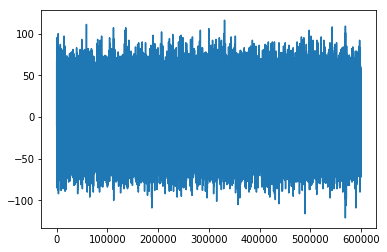

In [67]:
silence2_raw = wav_read('datasets/silence-threshold-tests/a-16x-withsilence.wav')
silence2 = silence2_raw[:600000]

silence2_stats = stats(silence2)
for stat in silence2_stats:
    print(f"{stat} = {silence2_stats[stat]}")
    
plt.plot(silence2)
plt.show()

#### Test 3 - Silence followed by several keystrokes (different keys, inconsistent pace)

length = 750000
mean = -0.47350933333333334
median = -1.0
max = 102
min = -101
std deviation = 20.25439809632909


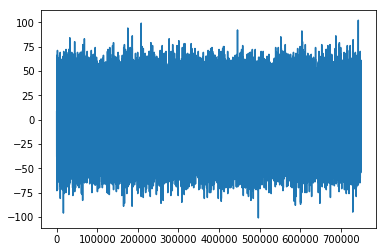

In [68]:
silence3_raw = wav_read('datasets/silence-threshold-tests/random-withsilence.wav')
silence3 = silence3_raw[:750000]

silence3_stats = stats(silence3)
for stat in silence3_stats:
    print(f'{stat} = {silence3_stats[stat]}')
plt.plot(silence3)
plt.show()

#### Test 4 - Silence followed by typing "hello "

length = 500000
mean = -0.476766
median = 0.0
max = 97
min = -96
std deviation = 19.28688591196733


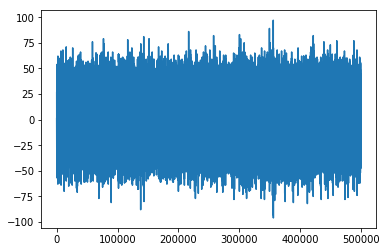

In [77]:
silence4_raw = wav_read('datasets/silence-threshold-tests/hello_.wav')
silence4 = silence4_raw[:500000]

silence4_stats = stats(silence4)
for stat in silence4_stats:
    print(f'{stat} = {silence4_stats[stat]}')
plt.plot(silence4)
plt.show()

#### Results

In [78]:
results = pd.DataFrame([silence1_stats, silence2_stats, silence3_stats, silence4_stats], 
                       index=['Test 1', 'Test 2', 'Test 3', 'Test 4'])
results

,length,max,mean,median,min,std deviation
Test 1,300000,104,-0.464423,0.0,-104,22.414488
Test 2,600000,116,-0.462460,0.0,-121,24.353048
Test 3,750000,102,-0.473509,-1.0,-101,20.254398
Test 4,500000,97,-0.476766,0.0,-96,19.286886


The recording software (GarageBand) samples wav values relative to the entire recording. For example, recording *just* silence results in large values during the silence compared to a recording of silence followed by a keystroke. Test 2 having a greater range and standard deviation can probably be attributed to the fact that the key pressed was "a", as opposed to the much louder "spacebar" and "random" in Tests 1 and 3. In Test 4, the microphone was placed on the table as opposed to near my mouth, which likely contributed to cleaner data.

### Sound preprocessing before keystroke extraction (maybe unnecessary)

In [8]:
def silence_threshold(sound_data, n):
    """Return the silence threshold of the sound data.
    The sound data should begin with n-seconds of silence.
    """
    sampling_rate = 44100
    num_samples   = sampling_rate * n
    silence       = sound_data[:num_samples]
    tolerance     = 40
    factor        = 11  # factor multiplied to threshold
    if np.std(silence) > tolerance:
        raise Exception(f'Sound data must begin with at least {n}s of silence.')
    else:
        return max(np.amax(silence), abs(np.amin(silence))) * factor

def remove_random_noise(sound_data):
    """Remove random noise from sound data."""
    threshold = silence_threshold(sound_data, 5)
    sound_data_copy = sound_data[:]
    for i in range(len(sound_data_copy)):
        if abs(sound_data_copy[i]) < threshold:
            sound_data_copy[i] = 0
    return sound_data_copy

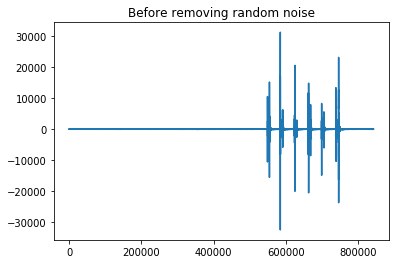

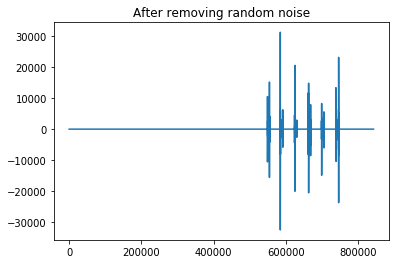

In [80]:
unprocessed_data = wav_read('datasets/samples/hello_.wav')
plt.plot(unprocessed_data)
plt.title('Before removing random noise')
plt.show()

processed_data = remove_random_noise(unprocessed_data)
plt.plot(processed_data)
plt.title('After removing random noise')
plt.show()

### Extracting keystrokes

In [9]:
def extract_keystrokes(sound_data):
    """Return array of arrays denoting each keystroke detected in the sound_data.
    
    Each keystroke consists of a push peak (touch peak and hit peak) and a release peak.
    Returned keystrokes are coerced to be the same length by appending trailing zeros.
    
    :type sound_file  -- NumPy array denoting input sound clip
    :type sample_rate -- integer denoting sample rate (samples per second)
    :rtype            -- NumPy array of NumPy arrays
    """
    threshold          = silence_threshold(sound_data, 5)
    keystroke_duration = 0.3  # seconds (initial guess)
    sample_rate        = 44100 # Hz
    sample_length      = int(sample_rate * keystroke_duration)
    
    keystrokes = []
    i = 0
    while i < len(sound_data):
        if abs(sound_data[i]) > threshold:
            sample_start, sample_end = i, i + sample_length
            if sample_end <= len(sound_data) and abs(sound_data[sample_end]) > threshold:
                j = sample_end
                while sound_data[j] > threshold:
                    j -= 1
                sample_end = j
            keystroke = sound_data[sample_start:sample_end]
            trailing_zeros = np.array([0 for _ in range(sample_length - (sample_end - sample_start))])
            keystroke = np.concatenate((keystroke, trailing_zeros))
            keystrokes.append(keystroke)
            i = sample_end - 1
        i += 1
    return np.array(keystrokes)

#### Testing

In [ ]:
def test_extract_keystrokes(data, expect):
    """Test if extract_keystrokes() extracts the correct number of keystrokes."""
    keystrokes = extract_keystrokes(data)
    actual = len(keystrokes)
    if expect == actual:
        print("Number of keystrokes matched!")
    else:
        print(f"Detected keystrokes mismatch. Found {actual} instead of {expect}.")
    
    
def run_extract_keystrokes_tests(test_set):
    base_dir = 'datasets/keystroke-extraction-tests/'
    for filename in test_set:
        wav_file = wav_read(base_dir + filename)
        expected = test_set[filename]
        test_extract_keystrokes(wav_file, expected)
        
        
test_set = {
    'hello_.wav': len('hello_'),
    'keyboard_.wav': len('keyboard_'),
    'password_.wav': len('password_'),
    'windsurfing_.wav': len('windsurfing_'),
    'zebra.wav': len('zebra'),
    'continental_drift_.wav': len('continental_drift_'),
    'jungle_cruise_.wav': len('jungle_cruise_'),
    'this_is_america.wav': len('this_is_america'),
}

run_extract_keystrokes_tests(test_set)

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


Number of keystrokes matched!
Number of keystrokes matched!
Number of keystrokes matched!
Number of keystrokes matched!
Number of keystrokes matched!


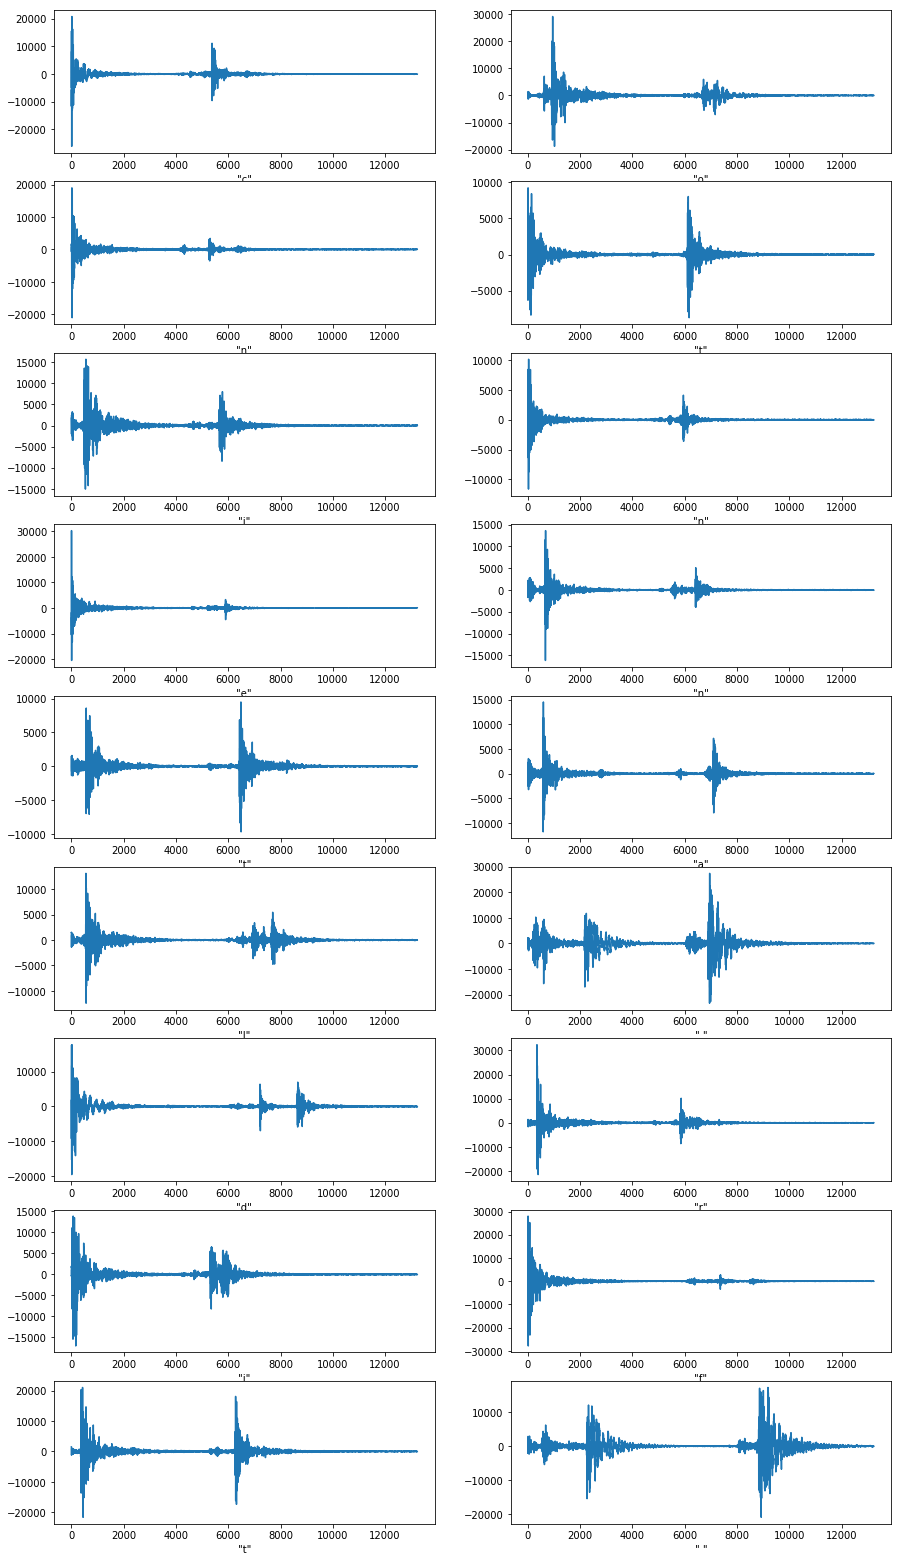

In [46]:
wav_data = wav_read('datasets/keystroke-extraction-tests/continental_drift_.wav')
keystrokes = extract_keystrokes(wav_data)

text = 'continental drift '
plt.figure(figsize=(15, 31))
n = len(keystrokes)
for i in range(n):
    plt.subplot(n / 2 + 1, 2, i + 1)
    plt.xlabel(f'"{text[i]}"')
    plt.plot(keystrokes[i])
plt.show()

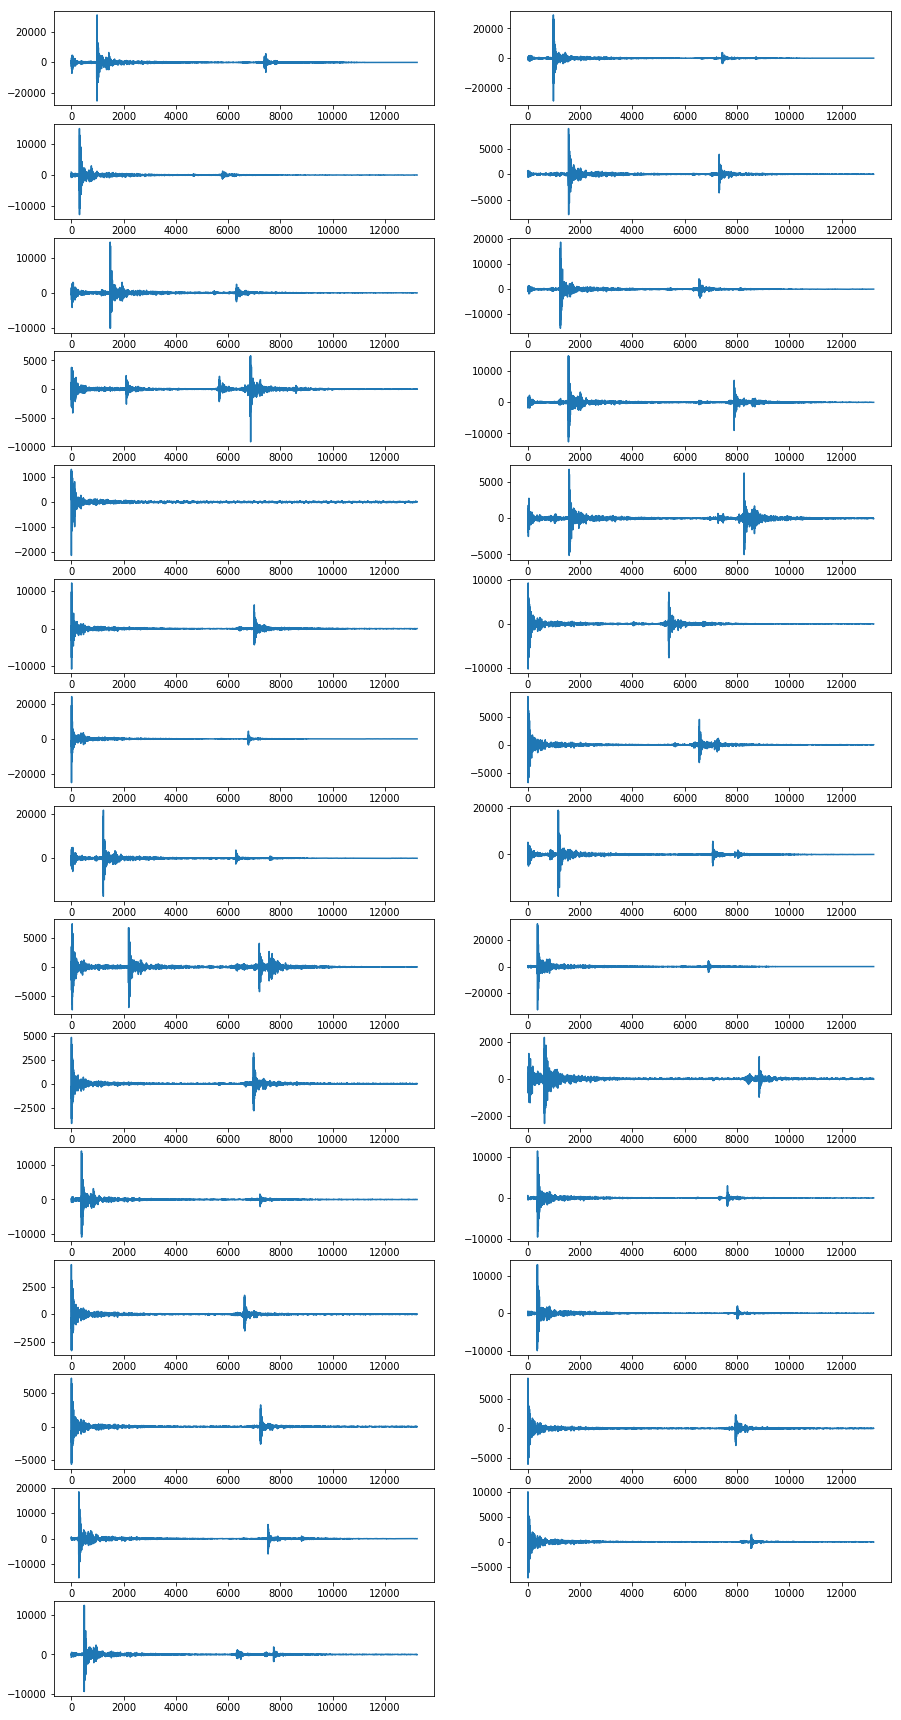

In [47]:
wav_data2 = wav_read('datasets/keystrokes/a/a-28x.wav')
keystrokes2 = extract_keystrokes(wav_data2)

plt.figure(figsize=(15, 31))
n = len(keystrokes2)
for i in range(n):
    plt.subplot(n / 2 + 1, 2, i + 1)
    plt.plot(keystrokes2[i])
plt.show()

In [45]:
print(len(keystrokes2))

29


## Collecting training/testing data

In [130]:
def load_keystroke_data(output=True):
    """Return a labeled dictionary of each key mapped to its keystroke data.
    
    :rtype -- dict('key_type': np.array(np.arrays))"""
    alphabet = [letter for letter in 'abcdefghijklmnopqrstuvwxyz']
    other_keys = ['space', 'comma', 'period', 'enter']
    keys = alphabet + other_keys
    
    labeled_keystrokes = {}
    for key in keys:
        wav_dir = 'datasets/keystrokes/' + key + '/'
        if output: print(f'> Reading files from {wav_dir} for key "{key}"')
        extract = []
        for file in os.listdir(wav_dir):
            if output: print(f'  > Reading data from "{file}"', end='')
            wav_data = wav_read(wav_dir + file)
            keystrokes = extract_keystrokes(wav_data)
            if output: print(f' => Found {len(keystrokes)} keystrokes')
            extract.extend(keystrokes)
        labeled_keystrokes[key] = np.array(extract)
    if output: print('> Done')
        
    return labeled_keystrokes

In [136]:
def scale_keystroke_data(data):
    """Scale each keystroke data to a value between 0 and 1.
    
    Returns a copy of data and doesn't modify data itself."""
    data_copy = deepcopy(data)
    for label in data_copy:
        for i in range(len(data_copy[label])):
            data_copy[label][i] /= max(data_copy[label][i])
    return data_copy

### Verifying data scaling

In [132]:
orig_data = load_keystroke_data()

> Reading files from datasets/keystrokes/a/ for key "a"
  > Reading data from "a-28x.wav"

/usr/local/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


 => Found 29 keystrokes
  > Reading data from "a-37x.wav" => Found 37 keystrokes
> Reading files from datasets/keystrokes/b/ for key "b"
> Reading files from datasets/keystrokes/c/ for key "c"
> Reading files from datasets/keystrokes/d/ for key "d"
> Reading files from datasets/keystrokes/e/ for key "e"
> Reading files from datasets/keystrokes/f/ for key "f"
> Reading files from datasets/keystrokes/g/ for key "g"
> Reading files from datasets/keystrokes/h/ for key "h"
> Reading files from datasets/keystrokes/i/ for key "i"
> Reading files from datasets/keystrokes/j/ for key "j"
> Reading files from datasets/keystrokes/k/ for key "k"
> Reading files from datasets/keystrokes/l/ for key "l"
> Reading files from datasets/keystrokes/m/ for key "m"
> Reading files from datasets/keystrokes/n/ for key "n"
> Reading files from datasets/keystrokes/o/ for key "o"
> Reading files from datasets/keystrokes/p/ for key "p"
> Reading files from datasets/keystrokes/q/ for key "q"
> Reading files from da

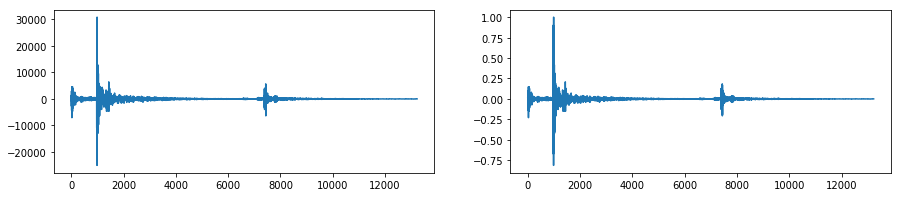

In [127]:
scaled_data = scale_keystroke_data(orig_data)
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(orig_data['a'][0])
plt.subplot(1, 2, 2)
plt.plot(scaled_data['a'][0])
plt.show()

## TensorFlow basics

In [98]:
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")


def f():
    return x*x*y + y + 2

result = f()
print(result)

tf.Tensor(42, shape=(), dtype=int32)


### Adam optimizer tutorial

In [105]:
print(tf.__version__)

2.0.0-alpha0


In [100]:
a = tf.Variable(4.0)
print(a.numpy())

4.0


In [110]:
def g(x): 
    return a * x

print(g(5))

tf.Tensor(20.0, shape=(), dtype=float32)


In [111]:
loss = lambda: abs(g(6) - 5)
print(loss)

<function <lambda> at 0x7fb6858931e0>


In [114]:
optimizer = tf.optimizers.Adam(learning_rate=1)
for _ in range(10):
    optimizer.minimize(loss, var_list=[a])
    print(a.numpy(), g(6))

1.0000021 tf.Tensor(6.000013, shape=(), dtype=float32)
5.90086e-06 tf.Tensor(3.540516e-05, shape=(), dtype=float32)
-0.26198745 tf.Tensor(-1.5719247, shape=(), dtype=float32)
-0.15701534 tf.Tensor(-0.94209206, shape=(), dtype=float32)
0.16651689 tf.Tensor(0.9991013, shape=(), dtype=float32)
0.63442236 tf.Tensor(3.8065343, shape=(), dtype=float32)
1.2043183 tf.Tensor(7.2259097, shape=(), dtype=float32)
1.4985683 tf.Tensor(8.991409, shape=(), dtype=float32)
1.5815398 tf.Tensor(9.489239, shape=(), dtype=float32)
1.4982384 tf.Tensor(8.98943, shape=(), dtype=float32)


### Hand-written digits

In [124]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0, 2),
    tf.keras.layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 7s 118us/sample - loss: 0.2573 - accuracy: 0.9261
Epoch 2/5
60000/60000 [==============================] - 7s 116us/sample - loss: 0.1140 - accuracy: 0.9663
Epoch 3/5
60000/60000 [==============================] - 8s 130us/sample - loss: 0.0787 - accuracy: 0.9755
Epoch 4/5
60000/60000 [==============================] - 9s 150us/sample - loss: 0.0596 - accuracy: 0.9813
Epoch 5/5
10000/10000 [==============================] - 1s 66us/sample - loss: 0.0845 - accuracy: 0.9741


[0.08447047669729218, 0.9741]

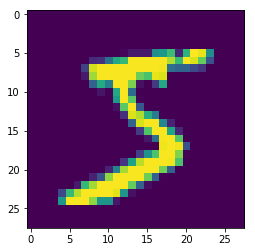

In [73]:
plt.figure()
plt.imshow(x_train[0])
plt.show()

## Application

In [134]:
raw_labeled_data = load_keystroke_data(output=False)
labeled_data = scale_keystroke_data(labeled_data)